# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# Define dictionary describing assignment of participants to the groups

# Groups
train_groups=['HCP']
test_dev_groups=['UoN']
test_groups=['CHIASM']

# Splits
train_split = 0.8
dev_split = 0.1
test_split = 0.1

# Dictionary with study design
design = {}

design['train']={}
design['train_dev']={}
design['test_dev']={}
design['test']={}

# Training data
for group in train_groups:

    # Idices of all subjects
    ids=[os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]
    
    # Randomize order
    random.shuffle(ids)
    
    # Find split ratios
    train_idx = np.int(np.floor(len(ids)*train_split))
    dev_idx = np.int(np.floor(len(ids)*(train_split+dev_split)))
    
    for i in range(len(ids)):
        
        path_to_folder='../../1_Data/1_Input/'+group+'/'+ids[i]+'/'
        
        files={}
        files['brain']=path_to_folder+'brain_skull-stripped.nii.gz'
        files['probs']=path_to_folder+'sampling_distribution.nii.gz'
        files['chiasm']=path_to_folder+'chiasm.nii.gz'
    
        if i+1<=train_idx:
            design['train'][ids[i]]=files
        elif i+1 > dev_idx:
            design['test'][ids[i]]=files
        else:
            design['train_dev'][ids[i]]=files
            
# Dev data
for group in test_dev_groups:

    # Idices of all subjects
    ids=[os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]
    
    for sub_id in ids:
        
        path_to_folder='../../1_Data/1_Input/'+group+'/'+sub_id+'/'
        
        files={}
        files['brain']=path_to_folder+'brain_skull-stripped.nii.gz'
        files['probs']=path_to_folder+'sampling_distribution.nii.gz'
        files['chiasm']=path_to_folder+'chiasm.nii.gz'
        
        design['test_dev'][sub_id]=files
    
# Test data
for group in test_groups:

    # Idices of all subjects
    ids=[os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]
    
    for sub_id in ids:
        
        path_to_folder='../../1_Data/1_Input/'+group+'/'+sub_id+'/'
        
        files={}
        files['brain']=path_to_folder+'brain_skull-stripped.nii.gz'
        files['probs']=path_to_folder+'sampling_distribution.nii.gz'
        files['chiasm']=path_to_folder+'chiasm.nii.gz'
        
        design['test'][sub_id]=files   

In [3]:
# Save the dictionary

In [4]:
# Dictionary with all images
subjects_list = {'train': [tio.Subject(
                            t1=tio.Image(design['train'][sub]['brain'], type=tio.INTENSITY),
                            probs = tio.Image(design['train'][sub]['probs'], type = tio.INTENSITY)) for sub in design['train']],
                'train_dev': [tio.Subject(
                            t1=tio.Image(design['train_dev'][sub]['brain'], type=tio.INTENSITY),
                            probs = tio.Image(design['train_dev'][sub]['probs'], type = tio.INTENSITY)) for sub in design['train_dev']],
                'test_dev':[tio.Subject(
                            t1=tio.Image(design['test_dev'][sub]['brain'], type=tio.INTENSITY),
                            probs = tio.Image(design['test_dev'][sub]['probs'], type = tio.INTENSITY)) for sub in design['test_dev']],
                'test':[tio.Subject(
                            t1=tio.Image(design['test'][sub]['brain'], type=tio.INTENSITY),
                            probs = tio.Image(design['test'][sub]['probs'], type = tio.INTENSITY)) for sub in design['test']]}

In [5]:
'''# Data preprocessing and augmentation

# Histogram standardization (to mitigate cross-site differences)

# For t1
t1_paths = [design['train'][sub]['brain'] for sub in design['train']]
t1_landmarks_path = Path('t1_landmarks.npy')

t1_landmarks = HistogramStandardization.train(t1_paths)
torch.save(t1_landmarks, t1_landmarks_path)

# For probs
probs_paths = [design['train'][sub]['probs'] for sub in design['train']]
probs_landmarks_path = Path('probs_landmarks.npy')

probs_landmarks = HistogramStandardization.train(probs_paths)
torch.save(probs_landmarks, probs_landmarks_path)

landmarks={'t1':t1_landmarks,#'t1_landmarks.npy',
            'probs': probs_landmarks}# 'probs_landmarks.npy'}

torch.save(landmarks, 'path_to_landmarks.pth')

standardize = HistogramStandardization('path_to_landmarks.pth')
'''
# Rescale
rescale = RescaleIntensity((0,1))

# Flip
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.25)

# Composing transforms - flip serves as data augmentation and is used only for training

transform_train = Compose([rescale, flip]) # leaving out standardization for now
transform_dev = Compose([rescale]) # leaving out standardization for now

In [6]:
# Torchio's (Pytorch's) Dataset
dataset = {'train': tio.SubjectsDataset(subjects_list['train'], transform = transform_train),
           'train_dev': tio.SubjectsDataset(subjects_list['train_dev'], transform = transform_dev),
           'test_dev': tio.SubjectsDataset(subjects_list['test_dev'], transform = transform_dev),
           'test': tio.SubjectsDataset(subjects_list['test'], transform = transform_dev)}

In [7]:
# Sampler
patch_size = (24,24,8)
queue_length = 600
samples_per_volume = 5

sampler = tio.data.WeightedSampler(patch_size,'probs')

In [8]:
# Dataloader
dataloader={'train': DataLoader( tio.Queue(dataset['train'], queue_length, samples_per_volume, sampler, num_workers=8), batch_size = 50),
            'train_dev': DataLoader( tio.Queue(dataset['train_dev'], queue_length, samples_per_volume, sampler, num_workers=8), batch_size = 50),
            'test_dev': DataLoader( tio.Queue(dataset['test_dev'], queue_length, samples_per_volume, sampler, num_workers=8), batch_size = 50),
            'test': DataLoader( tio.Queue(dataset['test'], queue_length, samples_per_volume, sampler, num_workers=8), batch_size = 50)
           }

In [9]:
# Testing

#num_epochs = 1

#model = torch.nn.Identity()

#for epoch_index in range(num_epochs):
#    for patches_batch in dataloader['test_dev']:
#        inputs = patches_batch['t1'][tio.DATA]  # key 't1' is in subject
#        targets = patches_batch['t1'][tio.DATA]  # key 'brain' is in subject
#        logits = model(inputs)  # model being an instance of torch.nn.Module
        
#inputs.shape
'''
fig = plt.figure(figsize=(20, 10))

for i in range(inputs.shape[0]):
    plt.subplot(5,8,i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
plt.show()'''

"\nfig = plt.figure(figsize=(20, 10))\n\nfor i in range(inputs.shape[0]):\n    plt.subplot(5,8,i+1)\n    plt.imshow(inputs[i,0,:,:,5],cmap='gray');\n    \nplt.show()"

# Network and parameters

In [10]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [11]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10):
        super(UNet, self).__init__()
        
        # Parameter determining depth of layers when going down the network
        features = init_features
        
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(features, features*2, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder3 = self.unet_block(features*2, features*4, name='enc3')
        self.pool3 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(features*4, features*4*2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv3 = nn.ConvTranspose3d(features*4*2, features*4, kernel_size=2, stride=2)
        self.decoder3 = self.unet_block(features*4, features*4, name='dec3')
        
        self.upconv2 = nn.ConvTranspose3d(features*2*2, features*2, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(features*2, features*2, name='dec2')
        
        self.upconv1 = nn.ConvTranspose3d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(features, features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec3 = self.upconv3(bottleneck)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.tanh(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        return bottleneck

In [12]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=64, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, int(init_features/scaling), name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(int(init_features/scaling), int(init_features/(scaling**2)), name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(int(init_features/(scaling**2)), int(init_features/scaling), kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(int(init_features/scaling), int(init_features/scaling), name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(int(init_features/scaling), init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [13]:
unet = UNet(1,1,64,2)
unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc1bnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc1bnorm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (encoder2): Sequential(
    (enc2conv1): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc2bnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc2bnorm2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affin

In [14]:
#sum(p.numel() for p in unet.parameters() if p.requires_grad)

#print(torch.version.cuda)

In [15]:
# try processing

#outputs = unet(inputs.to(device))
#outputs = outputs.cpu().detach().numpy()

#fig = plt.figure(figsize=(20, 10))

#for i in range(outputs.shape[0]):
#    plt.subplot(10,10,i+1)
#    plt.imshow(outputs[i,0,:,:,5],cmap='gray');
    
#plt.show()

In [16]:
# Criterion
#criterion = DiceLoss()
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(params=unet.parameters(), lr=0.0005)

# Number of epochs
n_epochs = 100

In [17]:
#outcome = criterion(inputs.to('cpu'), outputs.to('cpu'))

In [18]:
# INVESTIGATE CROSS ENTROPY LOSS

#print(criterion(1,2))

#print(criterion(inputs,inputs.to('cpu')))


In [19]:
#inputs[0].shape

In [20]:
'''fig = plt.figure(figsize=(20, 10))

for i in range(inputs.shape[0]):
    plt.subplot(10,10,i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
plt.show()'''

"fig = plt.figure(figsize=(20, 10))\n\nfor i in range(inputs.shape[0]):\n    plt.subplot(10,10,i+1)\n    plt.imshow(inputs[i,0,:,:,5],cmap='gray');\n    \nplt.show()"

In [21]:
'''fig = plt.figure(figsize=(20, 10))

outputs = outputs.cpu().detach().numpy()

for i in range(outputs.shape[0]):
    plt.subplot(10,10,i+1)
    plt.imshow(outputs[i,0,:,:,5],cmap='gray');
    
plt.show()'''

"fig = plt.figure(figsize=(20, 10))\n\noutputs = outputs.cpu().detach().numpy()\n\nfor i in range(outputs.shape[0]):\n    plt.subplot(10,10,i+1)\n    plt.imshow(outputs[i,0,:,:,5],cmap='gray');\n    \nplt.show()"

# Training

In [22]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, print_every, save_path):
    
    track_train_loss = []
    track_train_dev_loss = []
    track_test_dev_loss = []
    
    valid_loss_min = np.Inf
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0
        train_dev_loss = 0.0
        test_dev_loss = 0.0
        
        i = j = k = 0
        
        start = time.time()
        
        # Training
        model.train()
        
        for batch in dataloaders['train']:
            
            data = batch['t1']['data'].to(device)
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
            i+=1
            
        track_train_loss.append(train_loss/i)
        
        # Validation on two datasets
        model.eval()
        
        for batch in dataloaders['train_dev']:
            
            data = batch['t1']['data'].to(device)
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output,data)
                
                train_dev_loss += loss.item()
                j+=1
                
        track_train_dev_loss.append(train_dev_loss/j)
        
        
        for batch in dataloaders['test_dev']:
            
            data = batch['t1']['data'].to(device)
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output,data)
                
                test_dev_loss += loss.item()
                k+=1
                
        track_test_dev_loss.append(train_dev_loss/k)
        
        # Print summary of epoch
        duration = time.time() - start

        print('END OF EPOCH: {} \tTraining loss per batch: {:.6f}\tTraining_dev loss per batch: {:.6f}\tTest_dev loss per batch: {:.6f}'.format(epoch, train_loss/i, train_dev_loss/j, test_dev_loss/k))
       
        
        ## Save the model if reached min validation loss
        if train_dev_loss + test_dev_loss < valid_loss_min:
            valid_loss_min = train_dev_loss + test_dev_loss
            torch.save(model.state_dict(),save_path)
                        
    # return trained model
    return model, track_train_loss, track_train_dev_loss, track_test_dev_loss         

In [23]:
trained_model, train_loss, train_dev_loss, test_dev_loss = train_network(50, dataloader, unet, optimizer, criterion, device, 500,'50ep_0005lr.pt')

  2%|▏         | 1/50 [01:33<1:16:37, 93.83s/it]

END OF EPOCH: 1 	Training loss per batch: 0.011725	Training_dev loss per batch: 0.003251	Test_dev loss per batch: 0.001569


  4%|▍         | 2/50 [03:08<1:15:15, 94.08s/it]

END OF EPOCH: 2 	Training loss per batch: 0.003200	Training_dev loss per batch: 0.002541	Test_dev loss per batch: 0.001840


  6%|▌         | 3/50 [04:48<1:15:06, 95.89s/it]

END OF EPOCH: 3 	Training loss per batch: 0.002735	Training_dev loss per batch: 0.002252	Test_dev loss per batch: 0.001390


  8%|▊         | 4/50 [06:25<1:13:45, 96.21s/it]

END OF EPOCH: 4 	Training loss per batch: 0.002550	Training_dev loss per batch: 0.002143	Test_dev loss per batch: 0.002062


 10%|█         | 5/50 [08:00<1:11:47, 95.73s/it]

END OF EPOCH: 5 	Training loss per batch: 0.002323	Training_dev loss per batch: 0.002239	Test_dev loss per batch: 0.000997


 12%|█▏        | 6/50 [09:44<1:12:04, 98.29s/it]

END OF EPOCH: 6 	Training loss per batch: 0.002274	Training_dev loss per batch: 0.002084	Test_dev loss per batch: 0.000929


 14%|█▍        | 7/50 [11:19<1:09:43, 97.29s/it]

END OF EPOCH: 7 	Training loss per batch: 0.002035	Training_dev loss per batch: 0.001944	Test_dev loss per batch: 0.000930


 16%|█▌        | 8/50 [13:04<1:09:48, 99.74s/it]

END OF EPOCH: 8 	Training loss per batch: 0.002064	Training_dev loss per batch: 0.001813	Test_dev loss per batch: 0.000860


 18%|█▊        | 9/50 [14:40<1:07:24, 98.65s/it]

END OF EPOCH: 9 	Training loss per batch: 0.001930	Training_dev loss per batch: 0.001645	Test_dev loss per batch: 0.000797


 20%|██        | 10/50 [16:16<1:05:02, 97.57s/it]

END OF EPOCH: 10 	Training loss per batch: 0.001843	Training_dev loss per batch: 0.001481	Test_dev loss per batch: 0.000926


 22%|██▏       | 11/50 [18:00<1:04:46, 99.66s/it]

END OF EPOCH: 11 	Training loss per batch: 0.001718	Training_dev loss per batch: 0.002077	Test_dev loss per batch: 0.001010


 24%|██▍       | 12/50 [19:34<1:02:03, 97.98s/it]

END OF EPOCH: 12 	Training loss per batch: 0.001638	Training_dev loss per batch: 0.001471	Test_dev loss per batch: 0.000652


 26%|██▌       | 13/50 [21:16<1:01:11, 99.24s/it]

END OF EPOCH: 13 	Training loss per batch: 0.001580	Training_dev loss per batch: 0.001445	Test_dev loss per batch: 0.000656


 28%|██▊       | 14/50 [22:52<58:53, 98.15s/it]  

END OF EPOCH: 14 	Training loss per batch: 0.001606	Training_dev loss per batch: 0.001906	Test_dev loss per batch: 0.000906


 30%|███       | 15/50 [24:26<56:33, 96.97s/it]

END OF EPOCH: 15 	Training loss per batch: 0.001523	Training_dev loss per batch: 0.001353	Test_dev loss per batch: 0.000628


 32%|███▏      | 16/50 [26:06<55:24, 97.77s/it]

END OF EPOCH: 16 	Training loss per batch: 0.001509	Training_dev loss per batch: 0.001242	Test_dev loss per batch: 0.000657


 34%|███▍      | 17/50 [27:35<52:18, 95.11s/it]

END OF EPOCH: 17 	Training loss per batch: 0.001439	Training_dev loss per batch: 0.001248	Test_dev loss per batch: 0.000557


 36%|███▌      | 18/50 [29:11<50:58, 95.58s/it]

END OF EPOCH: 18 	Training loss per batch: 0.001432	Training_dev loss per batch: 0.001480	Test_dev loss per batch: 0.000709


 38%|███▊      | 19/50 [30:41<48:25, 93.71s/it]

END OF EPOCH: 19 	Training loss per batch: 0.001415	Training_dev loss per batch: 0.001264	Test_dev loss per batch: 0.000635


 40%|████      | 20/50 [32:09<46:00, 92.03s/it]

END OF EPOCH: 20 	Training loss per batch: 0.001486	Training_dev loss per batch: 0.001167	Test_dev loss per batch: 0.000548


 42%|████▏     | 21/50 [33:46<45:13, 93.56s/it]

END OF EPOCH: 21 	Training loss per batch: 0.001401	Training_dev loss per batch: 0.001151	Test_dev loss per batch: 0.000711


 44%|████▍     | 22/50 [35:15<43:02, 92.24s/it]

END OF EPOCH: 22 	Training loss per batch: 0.001383	Training_dev loss per batch: 0.001023	Test_dev loss per batch: 0.000543


 46%|████▌     | 23/50 [36:52<42:06, 93.57s/it]

END OF EPOCH: 23 	Training loss per batch: 0.001238	Training_dev loss per batch: 0.001348	Test_dev loss per batch: 0.000512


 48%|████▊     | 24/50 [38:21<39:55, 92.15s/it]

END OF EPOCH: 24 	Training loss per batch: 0.001247	Training_dev loss per batch: 0.001116	Test_dev loss per batch: 0.000557


 50%|█████     | 25/50 [39:49<37:53, 90.95s/it]

END OF EPOCH: 25 	Training loss per batch: 0.001268	Training_dev loss per batch: 0.000999	Test_dev loss per batch: 0.000518


 52%|█████▏    | 26/50 [41:26<37:08, 92.87s/it]

END OF EPOCH: 26 	Training loss per batch: 0.001219	Training_dev loss per batch: 0.002798	Test_dev loss per batch: 0.001360


 54%|█████▍    | 27/50 [42:55<35:09, 91.70s/it]

END OF EPOCH: 27 	Training loss per batch: 0.001237	Training_dev loss per batch: 0.001335	Test_dev loss per batch: 0.000618


 56%|█████▌    | 28/50 [44:32<34:10, 93.22s/it]

END OF EPOCH: 28 	Training loss per batch: 0.001282	Training_dev loss per batch: 0.001042	Test_dev loss per batch: 0.000722


 58%|█████▊    | 29/50 [46:00<32:08, 91.84s/it]

END OF EPOCH: 29 	Training loss per batch: 0.001324	Training_dev loss per batch: 0.001368	Test_dev loss per batch: 0.000770


 60%|██████    | 30/50 [47:27<30:05, 90.26s/it]

END OF EPOCH: 30 	Training loss per batch: 0.001170	Training_dev loss per batch: 0.001104	Test_dev loss per batch: 0.000643


 62%|██████▏   | 31/50 [49:04<29:15, 92.39s/it]

END OF EPOCH: 31 	Training loss per batch: 0.001218	Training_dev loss per batch: 0.001297	Test_dev loss per batch: 0.000676


 64%|██████▍   | 32/50 [50:33<27:22, 91.26s/it]

END OF EPOCH: 32 	Training loss per batch: 0.001150	Training_dev loss per batch: 0.001130	Test_dev loss per batch: 0.000536


 66%|██████▌   | 33/50 [52:10<26:18, 92.88s/it]

END OF EPOCH: 33 	Training loss per batch: 0.001167	Training_dev loss per batch: 0.001048	Test_dev loss per batch: 0.000528


 68%|██████▊   | 34/50 [53:38<24:26, 91.66s/it]

END OF EPOCH: 34 	Training loss per batch: 0.001211	Training_dev loss per batch: 0.001336	Test_dev loss per batch: 0.000538


 70%|███████   | 35/50 [55:06<22:38, 90.56s/it]

END OF EPOCH: 35 	Training loss per batch: 0.001156	Training_dev loss per batch: 0.001028	Test_dev loss per batch: 0.000441


 72%|███████▏  | 36/50 [56:44<21:38, 92.72s/it]

END OF EPOCH: 36 	Training loss per batch: 0.001207	Training_dev loss per batch: 0.002191	Test_dev loss per batch: 0.000503


 74%|███████▍  | 37/50 [58:13<19:49, 91.53s/it]

END OF EPOCH: 37 	Training loss per batch: 0.001181	Training_dev loss per batch: 0.000895	Test_dev loss per batch: 0.000514


 76%|███████▌  | 38/50 [59:50<18:37, 93.12s/it]

END OF EPOCH: 38 	Training loss per batch: 0.001226	Training_dev loss per batch: 0.001128	Test_dev loss per batch: 0.000625


 78%|███████▊  | 39/50 [1:01:19<16:50, 91.86s/it]

END OF EPOCH: 39 	Training loss per batch: 0.001080	Training_dev loss per batch: 0.001004	Test_dev loss per batch: 0.000775


 80%|████████  | 40/50 [1:02:47<15:07, 90.71s/it]

END OF EPOCH: 40 	Training loss per batch: 0.001124	Training_dev loss per batch: 0.001545	Test_dev loss per batch: 0.000852


 82%|████████▏ | 41/50 [1:04:24<13:55, 92.78s/it]

END OF EPOCH: 41 	Training loss per batch: 0.001086	Training_dev loss per batch: 0.000929	Test_dev loss per batch: 0.000453


 84%|████████▍ | 42/50 [1:05:53<12:13, 91.64s/it]

END OF EPOCH: 42 	Training loss per batch: 0.001078	Training_dev loss per batch: 0.001016	Test_dev loss per batch: 0.000566


 86%|████████▌ | 43/50 [1:07:30<10:51, 93.08s/it]

END OF EPOCH: 43 	Training loss per batch: 0.001122	Training_dev loss per batch: 0.000958	Test_dev loss per batch: 0.000479


 88%|████████▊ | 44/50 [1:08:59<09:11, 91.84s/it]

END OF EPOCH: 44 	Training loss per batch: 0.001106	Training_dev loss per batch: 0.000960	Test_dev loss per batch: 0.000458


 90%|█████████ | 45/50 [1:10:27<07:33, 90.71s/it]

END OF EPOCH: 45 	Training loss per batch: 0.001037	Training_dev loss per batch: 0.001026	Test_dev loss per batch: 0.000435


 92%|█████████▏| 46/50 [1:12:04<06:10, 92.70s/it]

END OF EPOCH: 46 	Training loss per batch: 0.001082	Training_dev loss per batch: 0.000893	Test_dev loss per batch: 0.000622


 94%|█████████▍| 47/50 [1:13:33<04:34, 91.63s/it]

END OF EPOCH: 47 	Training loss per batch: 0.001076	Training_dev loss per batch: 0.001114	Test_dev loss per batch: 0.000521


 96%|█████████▌| 48/50 [1:15:10<03:06, 93.08s/it]

END OF EPOCH: 48 	Training loss per batch: 0.001113	Training_dev loss per batch: 0.001052	Test_dev loss per batch: 0.000650


 98%|█████████▊| 49/50 [1:16:39<01:31, 91.84s/it]

END OF EPOCH: 49 	Training loss per batch: 0.001062	Training_dev loss per batch: 0.000995	Test_dev loss per batch: 0.000685


100%|██████████| 50/50 [1:18:06<00:00, 93.73s/it]

END OF EPOCH: 50 	Training loss per batch: 0.001053	Training_dev loss per batch: 0.000828	Test_dev loss per batch: 0.000439


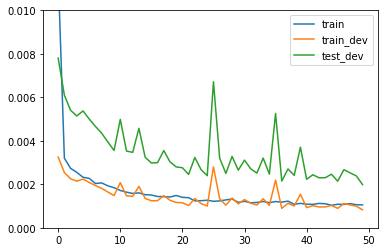

In [26]:
plt.plot(train_loss, label='train')
plt.plot(train_dev_loss, label='train_dev')
plt.plot(test_dev_loss, label='test_dev')
plt.ylim([0,0.01])
plt.legend()

In [27]:
# Load trained model
unet.load_state_dict(torch.load('50ep_0005lr.pt'))

<All keys matched successfully>

In [28]:
# Evaluate the model on all datasets

unet.eval()

for group in ['train', 'train_dev', 'test_dev']:
    
    i=0
    track_loss = 0
    
    for batch in dataloader[group]: 
        
            data = batch['t1']['data'].to(device)
            
            with torch.no_grad():
                
                output = unet(data)
                loss = criterion(output,data)
                
                track_loss += loss.item()
                i+=1
                
    print(group, ': loss per batch = ', track_loss/i)

train : loss per batch =  0.0008737075514044989
train_dev : loss per batch =  0.0008156118565239012
test_dev : loss per batch =  0.0004226477351039648


In [29]:
# Visualize the output (train_dev and test_dev)

# Generate sample from two dev datasets
train_dev_input = next(enumerate(dataloader['train_dev']))
test_dev_input = next(enumerate(dataloader['test_dev']))

In [30]:
# Run network on samples
train_dev_output = unet(train_dev_input[1]['t1']['data'].to(device))
test_dev_output = unet(test_dev_input[1]['t1']['data'].to(device))

In [31]:
# Extract latent representations

train_dev_latent = unet.output_latent_representations(train_dev_input[1]['t1']['data'].to(device))
test_dev_latent = unet.output_latent_representations(test_dev_input[1]['t1']['data'].to(device))

torch.Size([50, 1, 24, 24, 8])
torch.Size([50, 16, 6, 6, 2])
torch.Size([50, 1, 24, 24, 8])
torch.Size([50, 16, 6, 6, 2])


In [32]:
test_dev_latent.shape

torch.Size([50, 16, 6, 6, 2])

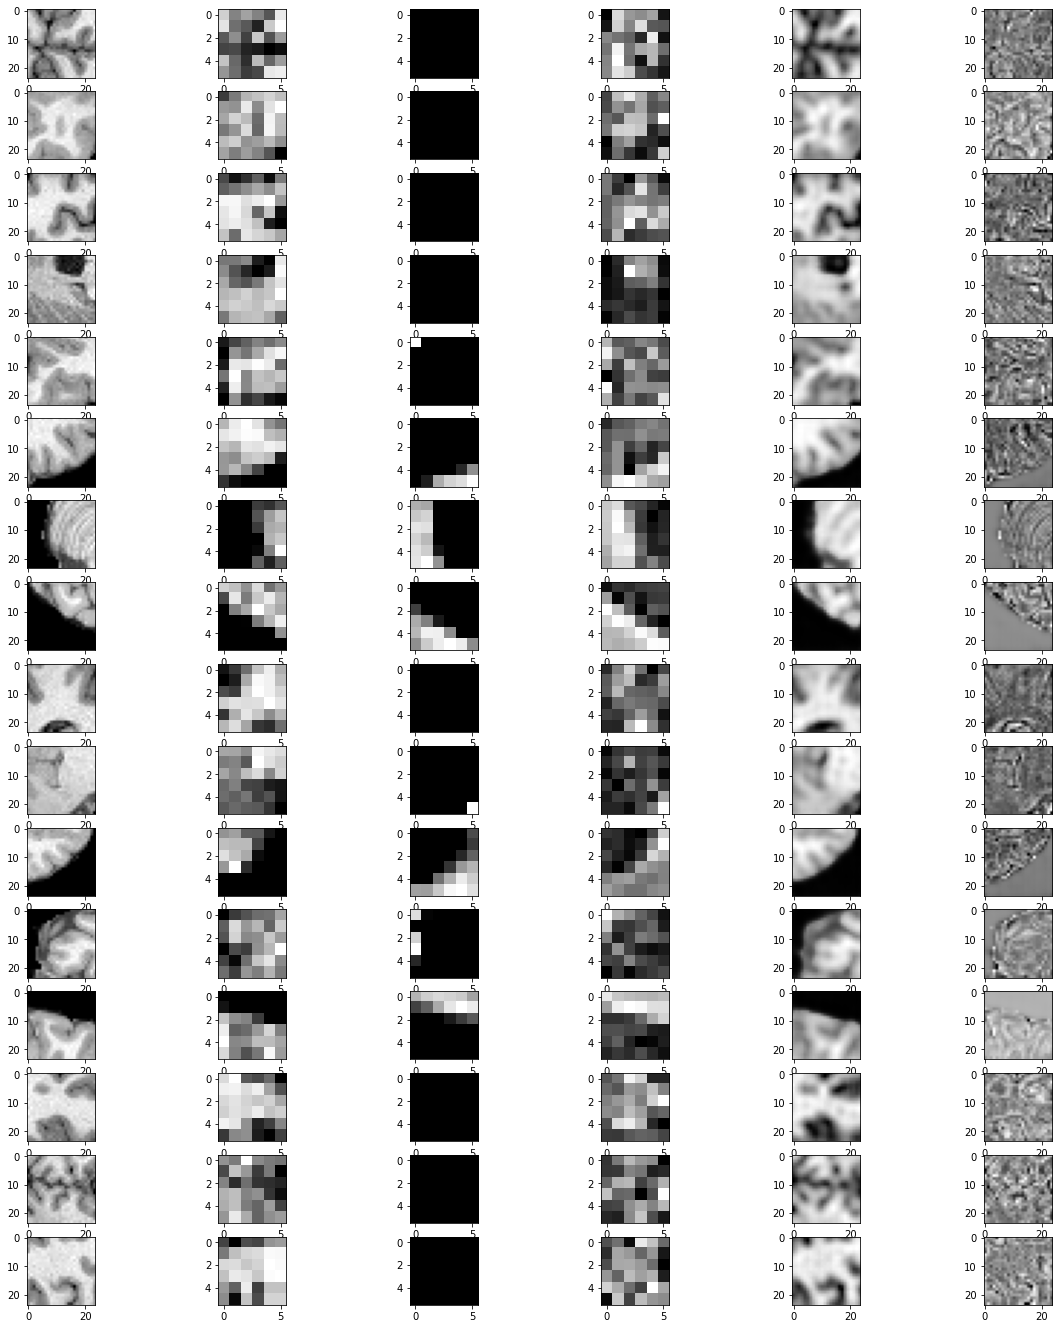

In [33]:
# Visualize train_dev sample

inputs = train_dev_input[1]['t1']['data'].to('cpu')
latent = train_dev_latent.cpu().detach().numpy()
outputs = train_dev_output.cpu().detach().numpy()

fig = plt.figure(figsize=(20,75))

for i in range(outputs.shape[0]//3):
    
    plt.subplot(outputs.shape[0],6,6*i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
    plt.subplot(outputs.shape[0],6,6*i+2)
    plt.imshow(latent[i,0,:,:,0],cmap='gray');
    
    plt.subplot(outputs.shape[0],6,6*i+3)
    plt.imshow(latent[i,1,:,:,0],cmap='gray');
    
    plt.subplot(outputs.shape[0],6,6*i+4)
    plt.imshow(latent[i,2,:,:,0],cmap='gray');
    
    plt.subplot(outputs.shape[0],6,6*i+5)
    plt.imshow(outputs[i,0,:,:,5], cmap ='gray')
    
    plt.subplot(outputs.shape[0],6,6*i+6)
    plt.imshow(inputs[i,0,:,:,5]-outputs[i,0,:,:,5], cmap ='gray')
    
plt.show()

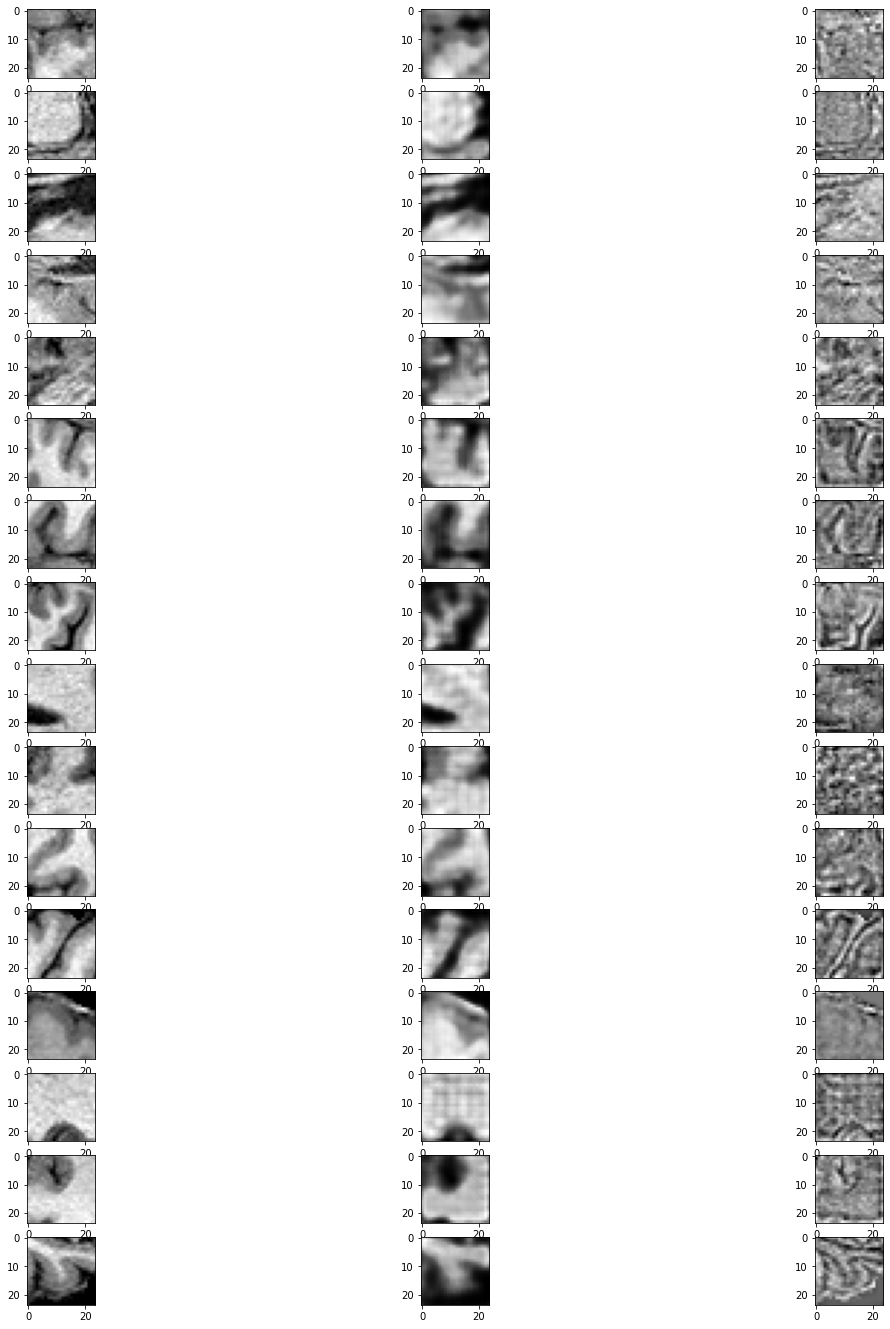

In [34]:
# Visualize test_dev sample

inputs = test_dev_input[1]['t1']['data'].to('cpu')
latent = test_dev_latent.cpu().detach().numpy()
outputs = test_dev_output.cpu().detach().numpy()

fig = plt.figure(figsize=(20,75))

for i in range(outputs.shape[0]//3):
    
    plt.subplot(outputs.shape[0],3,3*i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        
    plt.subplot(outputs.shape[0],3,3*i+2)
    plt.imshow(outputs[i,0,:,:,5], cmap ='gray')
    
    plt.subplot(outputs.shape[0],3,3*i+3)
    plt.imshow(inputs[i,0,:,:,5]-outputs[i,0,:,:,5], cmap ='gray')
    
plt.show()

# Evaluate and visualize results for chiasms


In [35]:
# Dictionary with all chiasm images
subjects_chiasms_list = {'train': [tio.Subject(t1=tio.Image(design['train'][sub]['chiasm'], type=tio.INTENSITY)) for sub in design['train']],
                'train_dev': [tio.Subject(t1=tio.Image(design['train_dev'][sub]['chiasm'], type=tio.INTENSITY)) for sub in design['train_dev']],
                'test_dev':[tio.Subject(t1=tio.Image(design['test_dev'][sub]['chiasm'], type=tio.INTENSITY)) for sub in design['test_dev']],
                'test':[tio.Subject(t1=tio.Image(design['test'][sub]['chiasm'], type=tio.INTENSITY)) for sub in design['test']]}

In [36]:
# Dataset containing only chiasm images
dataset_chiasms = {'train': tio.SubjectsDataset(subjects_chiasms_list['train'], transform = Compose([rescale])),
           'train_dev': tio.SubjectsDataset(subjects_chiasms_list['train_dev'], transform = Compose([rescale])),
           'test_dev': tio.SubjectsDataset(subjects_chiasms_list['test_dev'], transform = Compose([rescale])),
           'test': tio.SubjectsDataset(subjects_chiasms_list['test'], transform = Compose([rescale]))}

In [37]:
# Standard dataloader with images of chiasm
# Dataloader
dataloader_chiasms={'train': DataLoader(dataset=dataset_chiasms['train'], batch_size = 10, shuffle=True, num_workers =8),
            'train_dev': DataLoader(dataset=dataset_chiasms['train_dev'], batch_size = 10, shuffle=True, num_workers =8),
            'test_dev': DataLoader(dataset=dataset_chiasms['test_dev'], batch_size = 10, shuffle=True, num_workers =8),
            'test': DataLoader(dataset=dataset_chiasms['test'], batch_size = 10, shuffle=True, num_workers =8)
           }

train


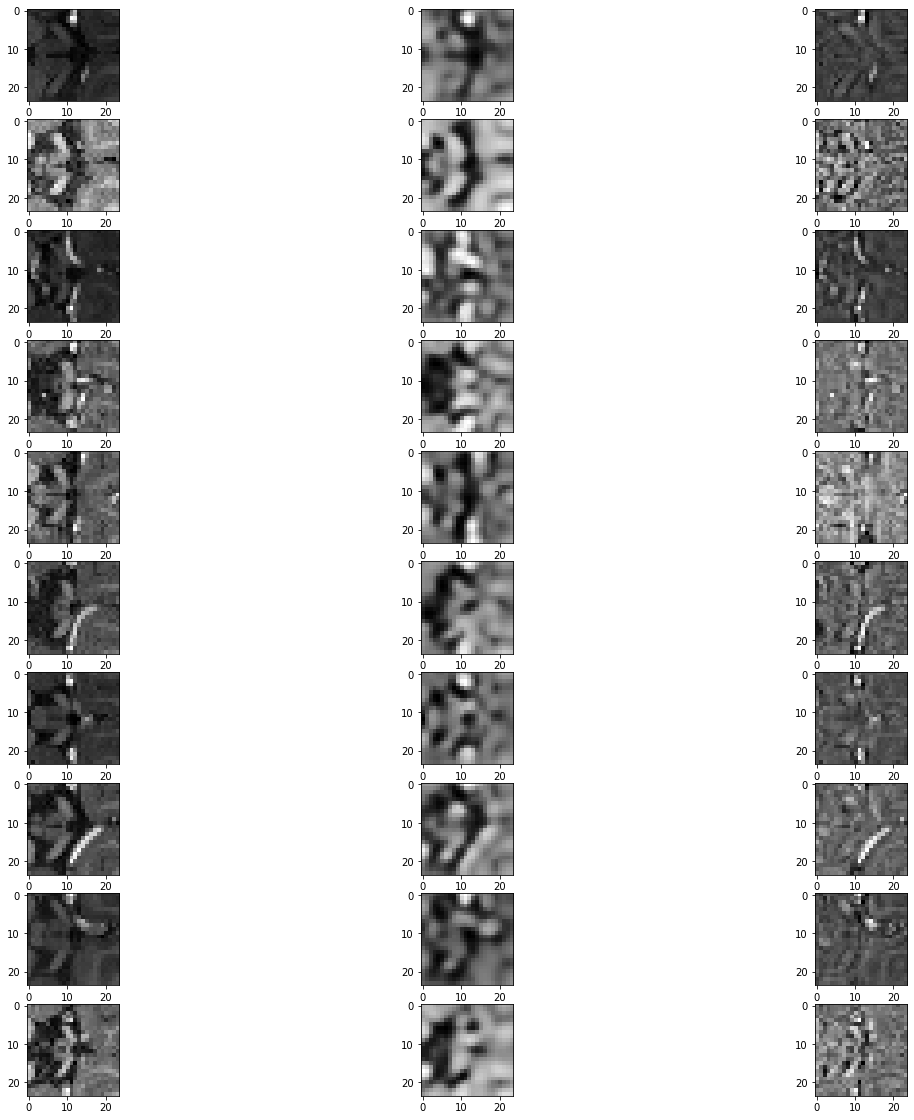

train_dev


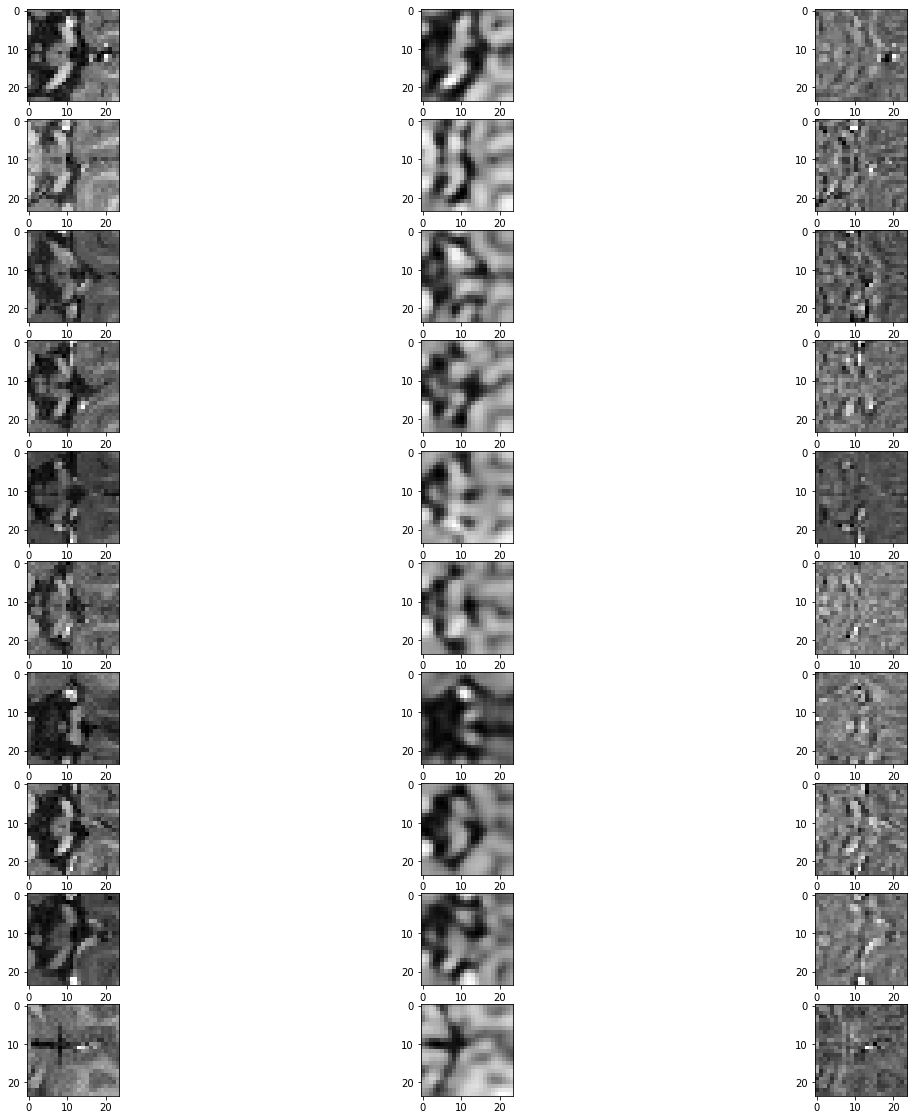

test_dev


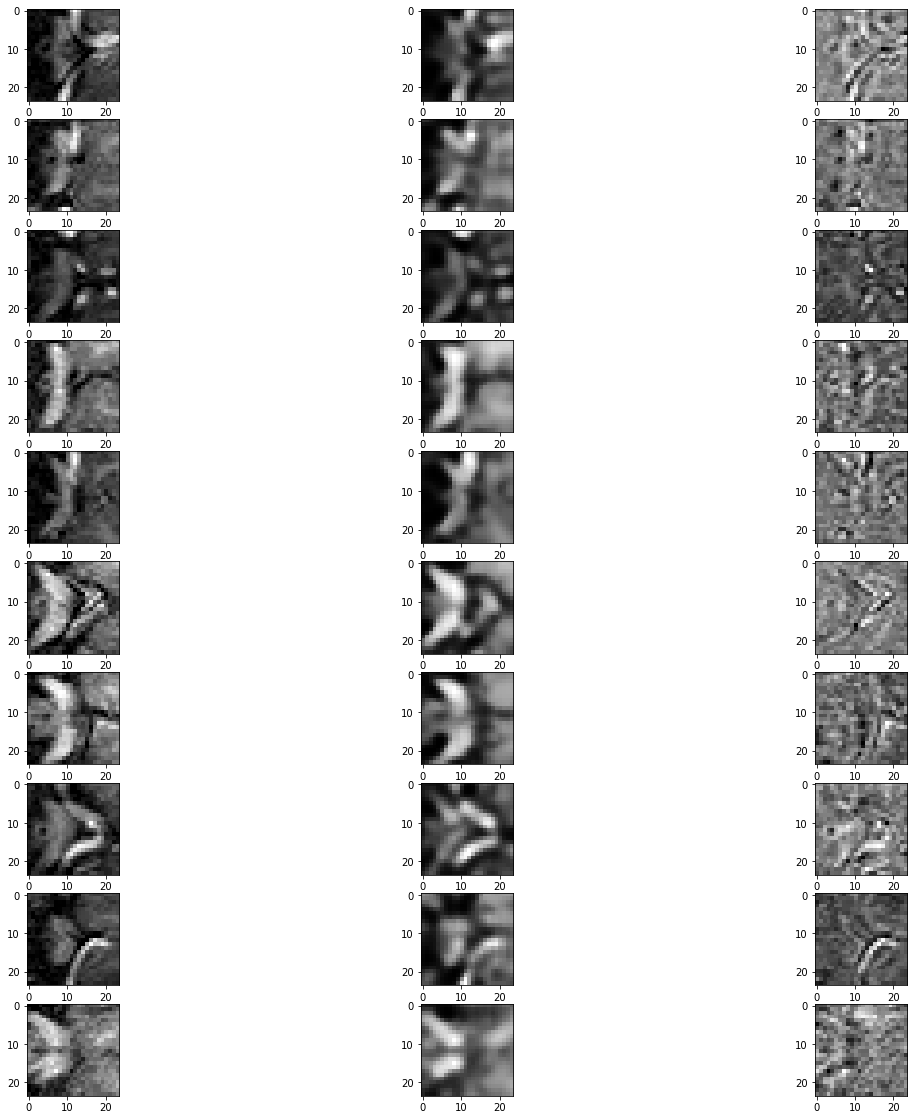

In [38]:
# Visualize results

unet.eval()

for group in ['train', 'train_dev', 'test_dev']:
    
    print(group)
    
    batch = next(enumerate(dataloader_chiasms[group]))
    
    data = batch[1]['t1']['data']
    
    output = unet(data.to(device))
    
    inputs = data.cpu().numpy()
    outputs = output.cpu().detach().numpy()
        
    fig = plt.figure(figsize=(20,20))
    
    for i in range(outputs.shape[0]):
        
        plt.subplot(outputs.shape[0],3,3*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');

        plt.subplot(outputs.shape[0],3,3*i+2)
        plt.imshow(outputs[i,0,:,:,5],cmap='gray');
        
        plt.subplot(outputs.shape[0],3,3*i+3)
        plt.imshow(inputs[i,0,:,:,5]-outputs[i,0,:,:,5],cmap='gray');
    
    
    plt.show()

In [39]:
batch = next(enumerate(dataloader_chiasms['train']))
print(batch[1]['t1']['data'].shape)

torch.Size([10, 1, 24, 24, 8])
